In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 


#filter
import scipy
from scipy.signal import cheby1
#hilbert
from scipy.signal import hilbert
from scipy.fft import fft,fftfreq,ifft

import wfdb

In [50]:
plt.rcParams["figure.figsize"] = (20,11)
plt.rcParams["font.size"] = 16
#plt.rcParams.update({"text.usetex": True,"font.family": "sans-serif","font.sans-serif": ["Helvetica"]})

구현 논문 링크 : https://www.sciencedirect.com/science/article/pii/S1746809411000292

# 0. open signal

In [3]:
#from file 
#xn = pd.read_csv("signal/210.csv",header=None)
#xn = xn.to_numpy().flatten()
#from record
signal_number = 210 #@param {type:"slider", min:0, max:9, step:1}
filename = f'mitbih/{str(signal_number)}'
xn = wfdb.rdsamp(filename,channels=[0])[0]

In [4]:
xn

array([[-0.065],
       [-0.065],
       [-0.065],
       ...,
       [-0.305],
       [-0.3  ],
       [ 0.   ]])

In [5]:
xn = xn.flatten()

In [6]:
xn

array([-0.065, -0.065, -0.065, ..., -0.305, -0.3  ,  0.   ])

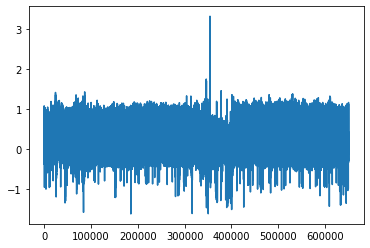

In [7]:
plt.plot(xn)

In [8]:
cnt = 0
S = 5

[0, 1800]


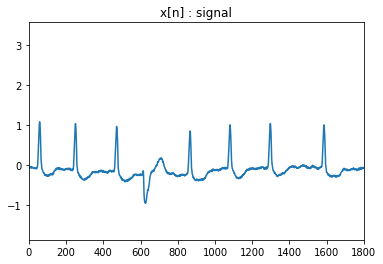

In [9]:
xAxis = [360*cnt,360*(cnt+S)]
print(xAxis)

plt.subplot(1,1,1).set_title("x[n] : signal")
plt.plot(xn)
plt.xlim(xAxis)


cnt += S

# 1. Linear Digital Filtering

## 1-1. BPF

In [10]:
FS = 360

In [11]:
bpfs = [6,18]

In [12]:
bpfs

[6, 18]

In [13]:
bpf = cheby1(4,1,bpfs,btype='bandpass',fs=FS,output="sos")

In [14]:
bpf

array([[ 2.68355692e-05,  5.36711383e-05,  2.68355692e-05,
         1.00000000e+00, -1.86599584e+00,  9.16639887e-01],
       [ 1.00000000e+00,  2.00000000e+00,  1.00000000e+00,
         1.00000000e+00, -1.92713057e+00,  9.47067789e-01],
       [ 1.00000000e+00, -2.00000000e+00,  1.00000000e+00,
         1.00000000e+00, -1.86320614e+00,  9.57697067e-01],
       [ 1.00000000e+00, -2.00000000e+00,  1.00000000e+00,
         1.00000000e+00, -1.97425434e+00,  9.85285911e-01]])

In [15]:
#지연 ㅇ
#fn = scipy.signal.sosfilt(bpf,xn)

In [16]:
#지연x 
fn = scipy.signal.sosfiltfilt(bpf,xn)

In [17]:
cnt = 0
S = 5

[0, 1800]


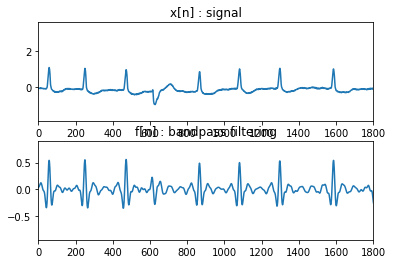

In [18]:
xAxis = [360*cnt,360*(cnt+S)]
print(xAxis)

plt.subplot(2,1,1).set_title("x[n] : signal")
plt.plot(xn)
plt.xlim(xAxis)
plt.subplot(2,1,2).set_title("f[n] : bandpass filtering")
plt.plot(fn)
plt.xlim(xAxis)

cnt += S

## 1-2. diff

In [19]:
dn = np.diff(fn,n=1)

In [20]:
dn

array([ 4.37316262e-03,  4.56969214e-03,  5.18405486e-03, ...,
       -3.09636474e-03, -1.51926317e-05,  2.48310471e-03])

## 1-3. Amplitude Normalization

In [21]:
dn_max = abs(dn.max())

In [22]:
dn_max

0.14209240056038583

In [23]:
dnTilde = dn / dn_max

In [24]:
cnt = 0
S = 5

[0, 1800]


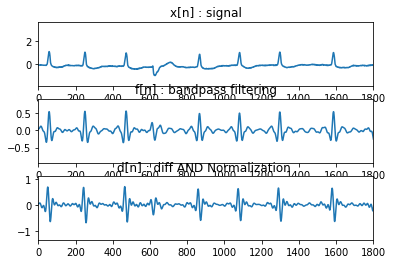

In [25]:
xAxis = [360*cnt,360*(cnt+S)]
print(xAxis)

plt.subplot(3,1,1).set_title("x[n] : signal")
plt.plot(xn)
plt.xlim(xAxis)
plt.subplot(3,1,2).set_title("f[n] : bandpass filtering")
plt.plot(fn)
plt.xlim(xAxis)
plt.subplot(3,1,3).set_title("d[n] : diff AND Normalization ")
plt.plot(dnTilde)
plt.xlim(xAxis)

cnt += S

# 2. Smmoth SE Envelope Extraction

## 2-1.Shannon Energy Computation

In [26]:
sn = np.zeros(len(dnTilde))

for i in range(len(dnTilde)):
    sn[i] = -abs(pow(dnTilde[i],2)) * math.log(abs(pow(dnTilde[i],2)))


## 	2-2. Zero-Phase Filtering (convoluction)

In [27]:
cvf =  np.repeat([0., 1., 0.], 54)

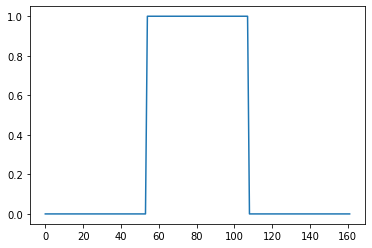

In [28]:
plt.plot(cvf)

In [29]:
snTilde = scipy.signal.convolve(sn, cvf, mode='same') / sum(cvf)

In [30]:
cnt = 0
S = 5

[0, 1800]


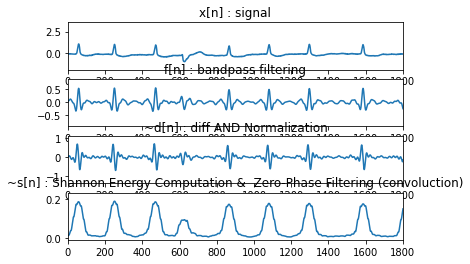

In [31]:
xAxis = [360*cnt,360*(cnt+S)]
print(xAxis)

plt.subplot(4,1,1).set_title("x[n] : signal")
plt.plot(xn)
plt.xlim(xAxis)
plt.subplot(4,1,2).set_title("f[n] : bandpass filtering")
plt.plot(fn)
plt.xlim(xAxis)
plt.subplot(4,1,3).set_title("~d[n] : diff AND Normalization")
plt.plot(dnTilde)
plt.xlim(xAxis)
plt.subplot(4,1,4).set_title("~s[n] : Shannon Energy Computation &  Zero-Phase Filtering (convoluction)")
plt.plot(snTilde)
plt.xlim(xAxis)

cnt += S

# 3. Peak Find Logic 

## 3-1. Hilbert Transformation

In [32]:
# 누가 구현해놓은 hilbert 변환 
# https://stackoverflow.com/questions/56380536/hilbert-transform-in-python
def hilbert_from_scratch(u):
    # N : fft length
    # M : number of elements to zero out
    # U : DFT of u
    # v : IDFT of H(U)

    N = len(u)
    # take forward Fourier transform
    U = fft(u)
    M = N - N//2 - 1
    # zero out negative frequency components
    U[N//2+1:] = [0] * M
    # double fft energy except @ DC0
    U[1:N//2] = 2 * U[1:N//2]
    # take inverse Fourier transform
    v = ifft(U)

    return v

In [33]:
# hilbert 변환 scipy 사용 : 이상하게 나옴   -> 실수부분만 plot되서 그런거였음
snHTAll = hilbert(snTilde)


In [34]:
# plt.plot(snHT)
# plt.xlim([0,360*20])

(0.0, 1080.0)

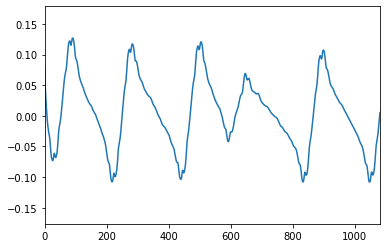

In [35]:
#왜 허수일까 뭘 놓친걸까 
plt.plot(np.imag(snHTAll))
plt.xlim([0,360*3])

In [36]:
snHT = np.imag(snHTAll)

In [37]:
cnt = 0
S = 5

[0, 1800]


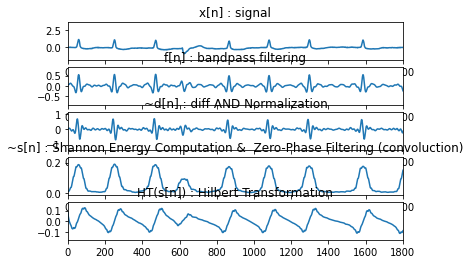

In [38]:
xAxis = [360*cnt,360*(cnt+S)]
print(xAxis)

plt.subplot(5,1,1).set_title("x[n] : signal")
plt.plot(xn)
plt.xlim(xAxis)
plt.subplot(5,1,2).set_title("f[n] : bandpass filtering")
plt.plot(fn)
plt.xlim(xAxis)
plt.subplot(5,1,3).set_title("~d[n] : diff AND Normalization")
plt.plot(dnTilde)
plt.xlim(xAxis)
plt.subplot(5,1,4).set_title("~s[n] : Shannon Energy Computation &  Zero-Phase Filtering (convoluction)")
plt.plot(snTilde)
plt.xlim(xAxis)
plt.subplot(5,1,5).set_title("HT(s[n]) : Hilbert Transformation")
plt.plot(snHT)
plt.xlim(xAxis)

cnt += S

## 3-2. Moving Average Filtering

In [39]:
#. The low-frequency drift is effectively removed by subtracting the output of the MA filter from the original input

In [40]:
#너무 느리다 나중에 구조 바꾸자 
zn = np.zeros(len(snHT))
for i in range(len(snHT)):
    tmp = 0
    cnt = 0
    for j in range(i,i-900,-1):
        if(j>=0):
            tmp +=snHT[j]
            cnt += 1
    tmp = tmp / 900
    zn[i] = snHT[i] - tmp


In [41]:
cnt = 0
S = 5

[0, 1800]


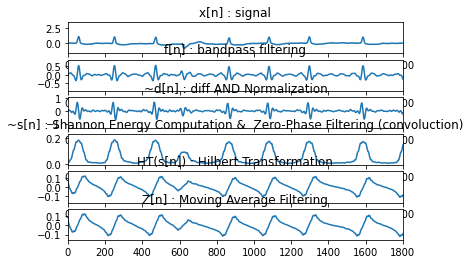

In [42]:
xAxis = [360*cnt,360*(cnt+S)]
print(xAxis)

plt.subplot(6,1,1).set_title("x[n] : signal")
plt.plot(xn)
plt.xlim(xAxis)
plt.subplot(6,1,2).set_title("f[n] : bandpass filtering")
plt.plot(fn)
plt.xlim(xAxis)
plt.subplot(6,1,3).set_title("~d[n] : diff AND Normalization")
plt.plot(dnTilde)
plt.xlim(xAxis)
plt.subplot(6,1,4).set_title("~s[n] : Shannon Energy Computation &  Zero-Phase Filtering (convoluction)")
plt.plot(snTilde)
plt.xlim(xAxis)
plt.subplot(6,1,5).set_title("HT(s[n]) : Hilbert Transformation")
plt.plot(snHT)
plt.xlim(xAxis)
plt.subplot(6,1,6).set_title("Z[n] : Moving Average Filtering")
plt.plot(zn)
plt.xlim(xAxis)

cnt += S

## 3-3. Zero Crossing Point Detection 

In [43]:
zcp = np.zeros(len(zn))

In [44]:
#. Finally,
# the zero-crossings accompanied by negative to positive transition
# are detected and used as guides to locate candidate R-peaks in the
# Shannon energy envelogram. The output of positive zero-crossing
# point(ZCP)detector is showninFig. 5(g), whichshows thatthe locations of the impulses correspond to the peaks of candidate R-wa

prev = 1
for i in range(len(zcp)):
    if(np.sign(prev) ==-1 and np.sign(zn[i]) ==1):
        zcp[i] = 1
    prev = zn[i]

In [45]:
cnt = 0
S = 5

[0, 1800]


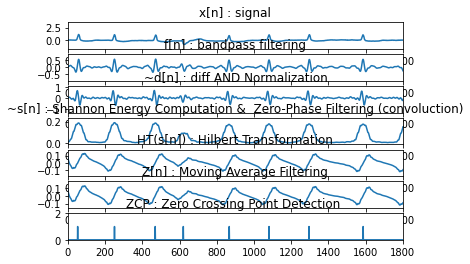

In [46]:
xAxis = [360*cnt,360*(cnt+S)]
print(xAxis)

plt.subplot(7,1,1).set_title("x[n] : signal")
plt.plot(xn)
plt.xlim(xAxis)
plt.subplot(7,1,2).set_title("f[n] : bandpass filtering")
plt.plot(fn)
plt.xlim(xAxis)
plt.subplot(7,1,3).set_title("~d[n] : diff AND Normalization")
plt.plot(dnTilde)
plt.xlim(xAxis)
plt.subplot(7,1,4).set_title("~s[n] : Shannon Energy Computation &  Zero-Phase Filtering (convoluction)")
plt.plot(snTilde)
plt.xlim(xAxis)
plt.subplot(7,1,5).set_title("HT(s[n]) : Hilbert Transformation")
plt.plot(snHT)
plt.xlim(xAxis)
plt.subplot(7,1,6).set_title("Z[n] : Moving Average Filtering")
plt.plot(zn)
plt.xlim(xAxis)
plt.subplot(7,1,7).set_title("ZCP : Zero Crossing Point Detection ")
plt.plot(zcp)
plt.xlim(xAxis)
plt.ylim([0,2])

cnt += S

## 4. R peak location detection 

In [47]:
#hat finds the correct time instants of the R-peaks in a ECG signal by searching the largest amplitude within ±25 samples of the
#identified location of the candidate R-peak in the previous step

#bandpass filtering delay 떄문에 잘 적용 안되는 듯 (논문에서는 filtering 이후 딜레이 안보임) 
final = np.full(len(xn),None)
for i in range(len(zcp)):
    if(zcp[i] == 1):
        tmp = -9999
        index = -1
        for j in range(i-25,i+25+1,1):
            if(j > 0 and j < len(zcp) and tmp < xn[j]):
                tmp = xn[j]
                index = j
        if(index!=-1):
            final[index] = xn[index]

In [52]:
cnt = 0
S = 10 * 6

[648000, 669600]


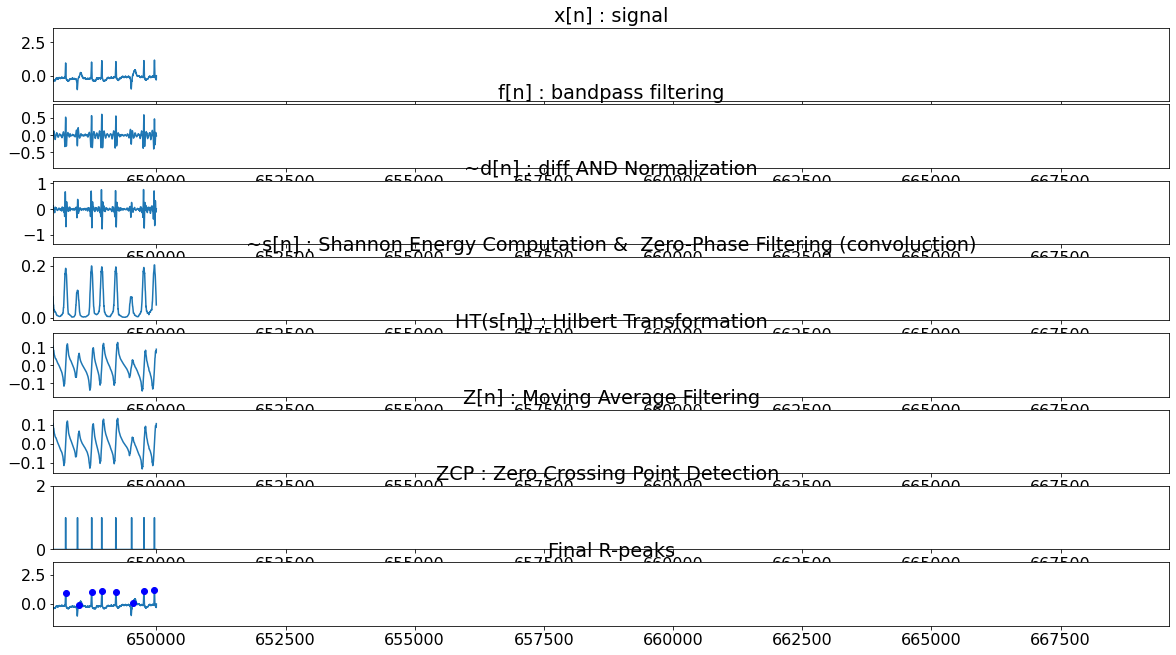

In [83]:
xAxis = [360*cnt,360*(cnt+S)]
print(xAxis)

plt.subplot(7,1,1).set_title("x[n] : signal")
plt.plot(xn)
plt.xlim(xAxis)
plt.subplot(8,1,2).set_title("f[n] : bandpass filtering")
plt.plot(fn)
plt.xlim(xAxis)
plt.subplot(8,1,3).set_title("~d[n] : diff AND Normalization")
plt.plot(dnTilde)
plt.xlim(xAxis)
plt.subplot(8,1,4).set_title("~s[n] : Shannon Energy Computation &  Zero-Phase Filtering (convoluction)")
plt.plot(snTilde)
plt.xlim(xAxis)
plt.subplot(8,1,5).set_title("HT(s[n]) : Hilbert Transformation")
plt.plot(snHT)
plt.xlim(xAxis)
plt.subplot(8,1,6).set_title("Z[n] : Moving Average Filtering")
plt.plot(zn)
plt.xlim(xAxis)
plt.subplot(8,1,7).set_title("ZCP : Zero Crossing Point Detection ")
plt.plot(zcp)
plt.xlim(xAxis)
plt.ylim([0,2])
plt.subplot(8,1,8).set_title("Final R-peaks")
plt.plot(xn)
plt.plot(final,"bo")
plt.xlim(xAxis)

cnt += S
